# CBC News Coronavirus/COVID-19 Articles (NLP)

#### Dataset Description
> <b> It contains the authors, the title, the publish date, the description about the story, the main story, and the url.</b>

## Building  an Abstractive News summarizer with Seq2Seq Model.

In [200]:
#from shutil import copyfile
#copyfile(src = "../input/attention/attention.py", dst = "../working/attention.py")

In [201]:
from attention import AttentionLayer

###### Import the Libraries

In [202]:
import numpy as np
import pandas as pd 
import re
import os
import json
import pickle
from tqdm import tqdm
import glob
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
from keras.preprocessing.text import Tokenizer 
from keras_preprocessing.sequence import pad_sequences
from nltk.corpus import stopwords
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed,Bidirectional
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
import warnings
pd.set_option("display.max_colwidth", 200)
warnings.filterwarnings("ignore")

In [203]:
os.listdir('articles/')


['Articles.csv']

In [204]:
df_news = pd.read_csv('articles/Articles.csv', encoding='latin-1')


In [205]:
df_news.head()

,Article,Date,Heading,NewsType
0,"KARACHI: The Sindh government has decided to bring down public transport fares by 7 per cent due to massive reduction in petroleum product prices by the federal government, Geo News reported.Sourc...",1/1/2015,sindh govt decides to cut public transport fares by 7pc kti rej,business
1,"HONG KONG: Asian markets started 2015 on an upswing in limited trading on Friday, with mainland Chinese stocks surging in Hong Kong on speculation Beijing may ease monetary policy to boost slowing...",1/2/2015,asia stocks up in new year trad,business
2,"HONG KONG: Hong Kong shares opened 0.66 percent lower Monday following a tepid lead from Wall Street, as the first full week of the new year kicked off.The benchmark Hang Seng Index dipped 158.63...",1/5/2015,hong kong stocks open 0.66 percent lower,business
3,HONG KONG: Asian markets tumbled Tuesday following painful losses in New York and Europe while the euro sat near nine-year lows as political uncertainty in Greece fanned renewed fears it could lea...,1/6/2015,asian stocks sink euro near nine year,business
4,NEW YORK: US oil prices Monday slipped below $50 a barrel for the first time in more than five years as the surging dollar and news of additional supplies extended a six-month rout.US benchmark We...,1/6/2015,us oil prices slip below 50 a barr,business


In [206]:
df_news.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2692 entries, 0 to 2691
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Article   2692 non-null   object
 1   Date      2692 non-null   object
 2   Heading   2692 non-null   object
 3   NewsType  2692 non-null   object
dtypes: object(4)
memory usage: 84.3+ KB


In [207]:
df_news.isna().sum()

Article     0
Date        0
Heading     0
NewsType    0
dtype: int64

In [208]:
data = df_news[['Heading','Article']]

In [209]:
data.head()

,Heading,Article
0,sindh govt decides to cut public transport fares by 7pc kti rej,"KARACHI: The Sindh government has decided to bring down public transport fares by 7 per cent due to massive reduction in petroleum product prices by the federal government, Geo News reported.Sourc..."
1,asia stocks up in new year trad,"HONG KONG: Asian markets started 2015 on an upswing in limited trading on Friday, with mainland Chinese stocks surging in Hong Kong on speculation Beijing may ease monetary policy to boost slowing..."
2,hong kong stocks open 0.66 percent lower,"HONG KONG: Hong Kong shares opened 0.66 percent lower Monday following a tepid lead from Wall Street, as the first full week of the new year kicked off.The benchmark Hang Seng Index dipped 158.63..."
3,asian stocks sink euro near nine year,HONG KONG: Asian markets tumbled Tuesday following painful losses in New York and Europe while the euro sat near nine-year lows as political uncertainty in Greece fanned renewed fears it could lea...
4,us oil prices slip below 50 a barr,NEW YORK: US oil prices Monday slipped below $50 a barrel for the first time in more than five years as the surging dollar and news of additional supplies extended a six-month rout.US benchmark We...


# Information about dataset

Let us look at datatypes and shape of the dataset

In [210]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2692 entries, 0 to 2691
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Heading  2692 non-null   object
 1   Article  2692 non-null   object
dtypes: object(2)
memory usage: 42.2+ KB


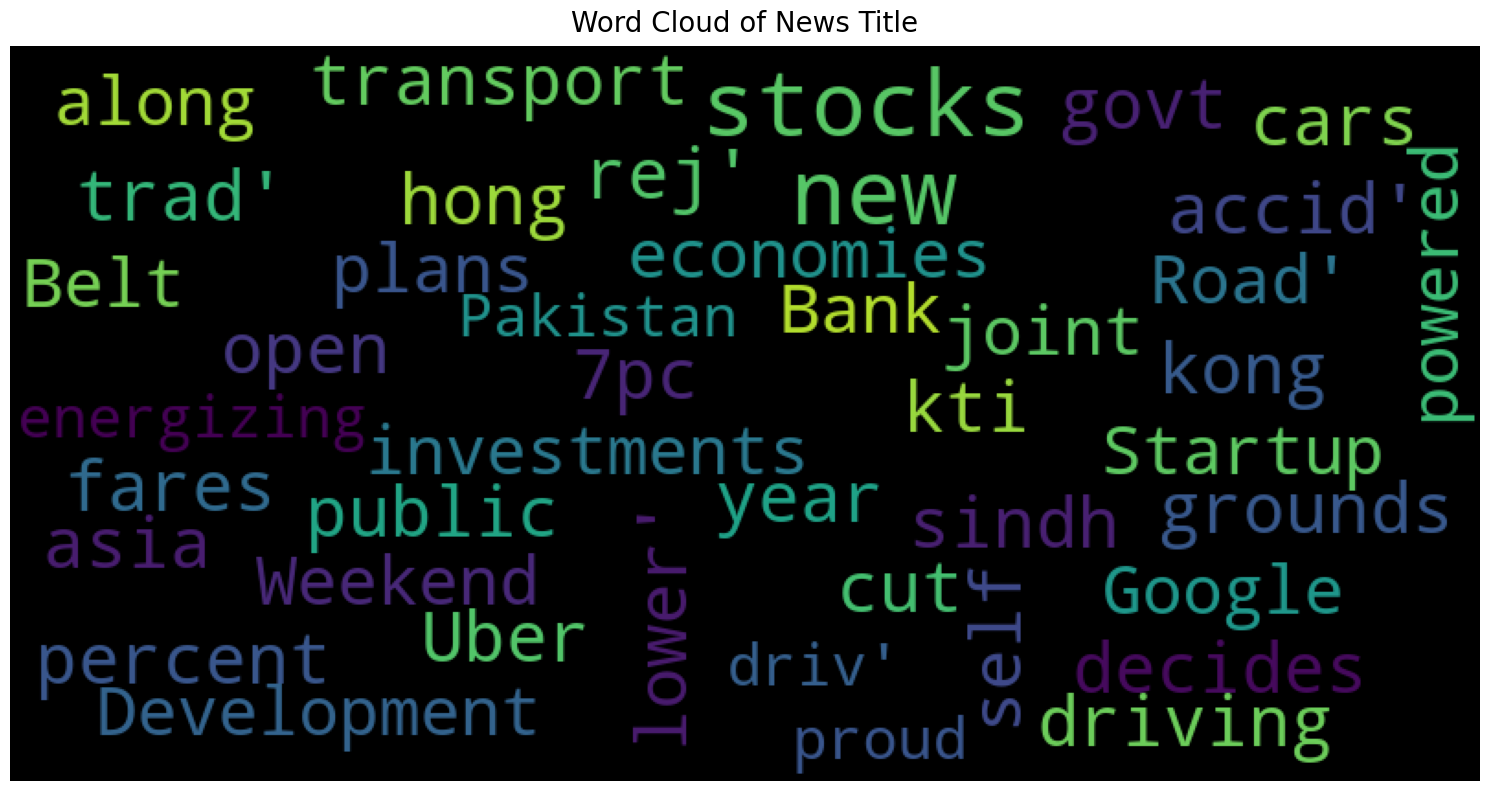

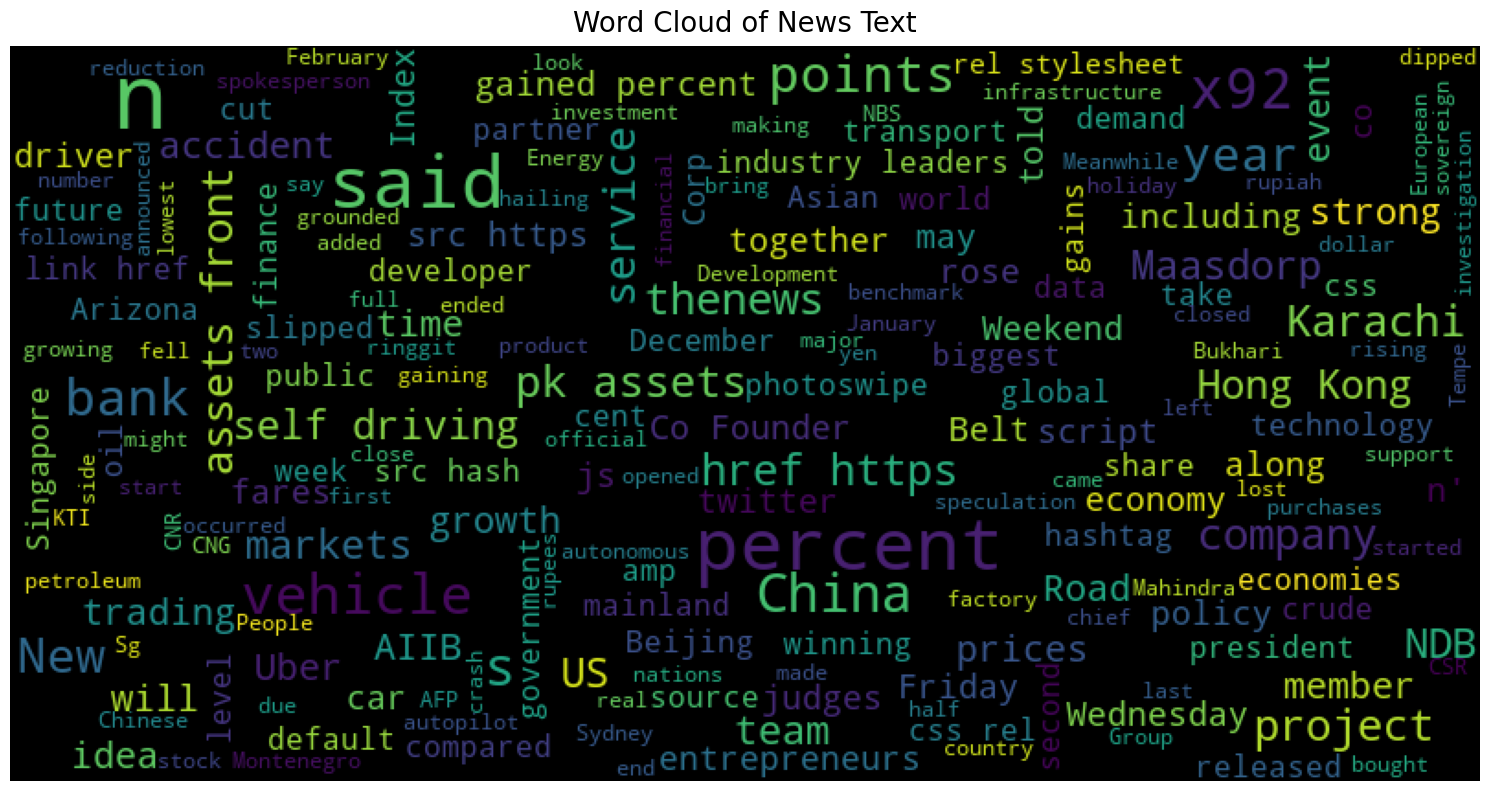

In [211]:
from wordcloud import WordCloud, STOPWORDS

# Thanks : https://www.kaggle.com/aashita/word-clouds-of-various-shapes ##
def plot_wordcloud(text, mask=None, max_words=200, max_font_size=50, figure_size=(15.0,15.0), 
                   title = None, title_size=20, image_color=False,color = None):
    stopwords = set(STOPWORDS)
    more_stopwords = {'one', 'br', 'Po', 'th', 'sayi', 'fo', 'Unknown'}
    stopwords = stopwords.union(more_stopwords)

    wordcloud = WordCloud(background_color=color,
                    stopwords = stopwords,
                    max_words = max_words,
                    max_font_size = max_font_size, 
                    random_state = 42,
                    width=800, 
                    height=400,
                    mask = mask)
    wordcloud.generate(str(text))
    
    plt.figure(figsize=figure_size)
    if image_color:
        image_colors = ImageColorGenerator(mask);
        plt.imshow(wordcloud.recolor(color_func=image_colors), interpolation="bilinear");
        plt.title(title, fontdict={'size': title_size,  
                                  'verticalalignment': 'bottom'})
    else:
        plt.imshow(wordcloud);
        plt.title(title, fontdict={'size': title_size, 'color': 'black', 
                                  'verticalalignment': 'bottom'})
    plt.axis('off');
    plt.tight_layout()  
    
plot_wordcloud(data['Heading'].values, title="Word Cloud of News Title",color = 'black')
plot_wordcloud(data['Article'].values, title="Word Cloud of News Text",color = 'black')

# Text Data Preprocessing

Performing basic preprocessing steps is very important before we get to the model building part. Using messy and uncleaned text data is a potentially disastrous move

In [212]:
contraction_mapping = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

We will perform the below preprocessing tasks for our data:

 - Convert everything to lowercase

 - Remove HTML tags

 - Contraction mapping

 - Remove (‘s)

 - Remove any text inside the parenthesis ( )

 - Eliminate punctuations and special characters

 -  Remove stopwords

 - Remove short words


In [213]:
stop_words = set(stopwords.words('english')) 

def text_cleaner(text,num):
    newString = text.lower()
    newString = BeautifulSoup(newString, "html.parser").text
    newString = re.sub(r'\([^)]*\)', '', newString)
    newString = re.sub('"','', newString)
    newString = ' '.join([contraction_mapping[t] if t in contraction_mapping else t for t in newString.split(" ")])    
    newString = re.sub(r"'s\b","",newString)
    newString = re.sub("[^a-zA-Z]", " ", newString) 
    newString = re.sub('[m]{2,}', 'mm', newString)
    if(num==0):
        tokens = [w for w in newString.split() if not w in stop_words]
    else:
        tokens=newString.split()
    long_words=[]
    for i in tokens:
        if len(i)>1:                                                 #removing short word
            long_words.append(i)   
    return (" ".join(long_words)).strip()

In [214]:
#call the function
cleaned_text = []
for t in data['Article']:
    cleaned_text.append(text_cleaner(t,0)) 

Let us look at the first five preprocessed text

In [215]:
cleaned_text[:5]  

['karachi sindh government decided bring public transport fares per cent due massive reduction petroleum product prices federal government geo news reported sources said reduction fares applicable public transport rickshaw taxi means traveling meanwhile karachi transport ittehad refused abide government decision kti president irshad bukhari said commuters charged lowest fares karachi compare parts country adding pc vehicles run compressed natural gas bukhari said karachi transporters cut fares decrease cng prices made',
 'hong kong asian markets started upswing limited trading friday mainland chinese stocks surging hong kong speculation beijing may ease monetary policy boost slowing growth hong kong rose percent closing points higher seoul closed percent rising points sydney gained percent points close singapore edged percent gaining points markets mainland china japan taiwan new zealand philippines thailand remained closed holidays mainland bourses shut january shares chinese develope

In [216]:
#call the function
cleaned_summary = []
for t in data['Heading']:
    cleaned_summary.append(text_cleaner(t,0))

Let us look at the first 10 preprocessed news titles

In [217]:
cleaned_summary[:10]

['sindh govt decides cut public transport fares pc kti rej',
 'asia stocks new year trad',
 'hong kong stocks open percent lower',
 'asian stocks sink euro near nine year',
 'us oil prices slip barr',
 'oil hits new year lows saudis defend',
 'bullish kse jumps psychological barrier',
 'oil falls asian trad',
 'sugar prices drop rs sind',
 'oil extends losses world bank cuts growth']

In [218]:
data['cleaned_text']=cleaned_text
data['cleaned_summary']=cleaned_summary

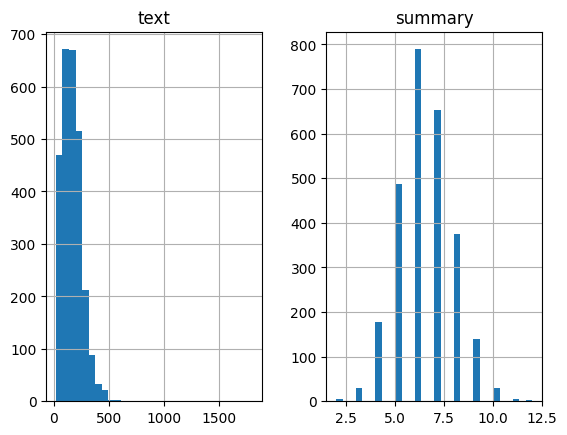

In [219]:
text_word_count = []
summary_word_count = []

# populate the lists with sentence lengths
for i in data['cleaned_text']:
      text_word_count.append(len(i.split()))

for i in data['cleaned_summary']:
      summary_word_count.append(len(i.split()))

length_df = pd.DataFrame({'text':text_word_count, 'summary':summary_word_count})

length_df.hist(bins = 30)
plt.show()

Add the **START** and **END** special tokens at the beginning and end of the summary.Add tokens at begining and end of news title  


In [220]:
data['cleaned_summary'] = data['cleaned_summary'].apply(lambda x : 'sostok '+ x + ' eostok')

In [221]:
max_text_len=300
max_summary_len=15

We are getting closer to the model building part. Before that, we need to split our dataset into a training and validation set. We’ll use 90% of the dataset as the training data and evaluate the performance on the remaining 10% (holdout set):

In [222]:
from sklearn.model_selection import train_test_split
x_tr,x_val,y_tr,y_val=train_test_split(np.array(data['cleaned_text']),np.array(data['cleaned_summary']),test_size=0.1,random_state=0,shuffle=True) 

In [223]:
from keras.preprocessing.text import Tokenizer 
from keras_preprocessing.sequence import pad_sequences

#prepare a tokenizer for reviews on training data
x_tokenizer = Tokenizer() 
x_tokenizer.fit_on_texts(list(x_tr))

In [224]:
thresh=4

cnt=0
tot_cnt=0
freq=0
tot_freq=0

for key,value in x_tokenizer.word_counts.items():
    tot_cnt=tot_cnt+1
    tot_freq=tot_freq+value
    if(value<thresh):
        cnt=cnt+1
        freq=freq+value
    
print("% of rare words in vocabulary:",(cnt/tot_cnt)*100)
print("Total Coverage of rare words:",(freq/tot_freq)*100)

% of rare words in vocabulary: 58.75279161656073
Total Coverage of rare words: 5.195149791733419


In [225]:
#prepare a tokenizer for reviews on training data
x_tokenizer = Tokenizer(num_words=tot_cnt-cnt) 
x_tokenizer.fit_on_texts(list(x_tr))

#convert text sequences into integer sequences
x_tr_seq    =   x_tokenizer.texts_to_sequences(x_tr) 
x_val_seq   =   x_tokenizer.texts_to_sequences(x_val)

#padding zero upto maximum lengath
x_tr    =   pad_sequences(x_tr_seq,maxlen=max_text_len, padding='post')
x_val   =   pad_sequences(x_val_seq,maxlen=max_text_len, padding='post')

#size of vocabulary ( +1 for padding token)
x_voc   =  x_tokenizer.num_words + 1

In [226]:
#prepare a tokenizer for reviews on training data
y_tokenizer = Tokenizer()   
y_tokenizer.fit_on_texts(list(y_tr))

In [227]:
thresh=6

cnt=0
tot_cnt=0
freq=0
tot_freq=0

for key,value in y_tokenizer.word_counts.items():
    tot_cnt=tot_cnt+1
    tot_freq=tot_freq+value
    if(value<thresh):
        cnt=cnt+1
        freq=freq+value
    
print("% of rare words in vocabulary:",(cnt/tot_cnt)*100)
print("Total Coverage of rare words:",(freq/tot_freq)*100)

% of rare words in vocabulary: 87.18008375988832
Total Coverage of rare words: 31.18475477644278


Let us define the tokenizer with top most common words for summary.

In [228]:
#prepare a tokenizer for reviews on training data
y_tokenizer = Tokenizer(num_words=tot_cnt-cnt) 
y_tokenizer.fit_on_texts(list(y_tr))

#convert text sequences into integer sequences
y_tr_seq    =   y_tokenizer.texts_to_sequences(y_tr) 
y_val_seq   =   y_tokenizer.texts_to_sequences(y_val) 

#padding zero upto maximum length
y_tr    =   pad_sequences(y_tr_seq, maxlen=max_summary_len, padding='post')
y_val   =   pad_sequences(y_val_seq, maxlen=max_summary_len, padding='post')

#size of vocabulary
y_voc  =   y_tokenizer.num_words +1

Let us check whether word count of start token is equal to length of the training data

In [229]:
y_tokenizer.word_counts['sostok'],len(y_tr)

(2422, 2422)

Delete start and end tokens

In [230]:
ind=[]
for i in range(len(y_tr)):
    cnt=0
    for j in y_tr[i]:
        if j!=0:
            cnt=cnt+1
    if(cnt==2):
        ind.append(i)

y_tr=np.delete(y_tr,ind, axis=0)
x_tr=np.delete(x_tr,ind, axis=0)

In [231]:
ind=[]
for i in range(len(y_val)):
    cnt=0
    for j in y_val[i]:
        if j!=0:
            cnt=cnt+1
    if(cnt==2):
        ind.append(i)

y_val=np.delete(y_val,ind, axis=0)
x_val=np.delete(x_val,ind, axis=0)

## NLP Model Building

In [232]:
from keras import backend as K 
K.clear_session()

latent_dim = 300
embedding_dim=100

# Encoder
encoder_inputs = Input(shape=(max_text_len,))

#embedding layer
enc_emb =  Embedding(x_voc, embedding_dim,trainable=True)(encoder_inputs)

#encoder lstm 1
encoder_lstm1 = LSTM(latent_dim,return_sequences=True,return_state=True,dropout=0.4,recurrent_dropout=0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

#encoder lstm 2
encoder_lstm2 = LSTM(latent_dim,return_sequences=True,return_state=True,dropout=0.4,recurrent_dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

#encoder lstm 3
encoder_lstm3=LSTM(latent_dim, return_state=True, return_sequences=True,dropout=0.4,recurrent_dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None,))

#embedding layer
dec_emb_layer = Embedding(y_voc, embedding_dim,trainable=True)
dec_emb = dec_emb_layer(decoder_inputs)

decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True,dropout=0.4,recurrent_dropout=0.2)
decoder_outputs,decoder_fwd_state, decoder_back_state = decoder_lstm(dec_emb,initial_state=[state_h, state_c])

# Attention layer
attn_layer = AttentionLayer(name='attention_layer')
attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs])

# Concat attention input and decoder LSTM output
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

#dense layer
decoder_dense =  TimeDistributed(Dense(y_voc, activation='softmax'))
decoder_outputs = decoder_dense(decoder_concat_input)

# Define the model 
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

model.summary() 

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 300)]        0           []                               
                                                                                                  
 embedding (Embedding)          (None, 300, 100)     960500      ['input_1[0][0]']                
                                                                                                  
 lstm (LSTM)                    [(None, 300, 300),   481200      ['embedding[0][0]']              
                                 (None, 300),                                                     
                                 (None, 300)]                                                     
                                                                                              

In [233]:
#converts the integer sequence to a one-hot vector using sparse_categorical_crossentropy
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')

Early Stopping - Our model will stop training once the validation loss increases:

In [234]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=2)

In [235]:
history=model.fit([x_tr,y_tr[:,:-1]], y_tr.reshape(y_tr.shape[0],y_tr.shape[1], 1)[:,1:] ,epochs=50,callbacks=[es],batch_size=128, validation_data=([x_val,y_val[:,:-1]], y_val.reshape(y_val.shape[0],y_val.shape[1], 1)[:,1:]))

Epoch 1/50
 9/19 [=============>................] - ETA: 8:28 - loss: 3.7558

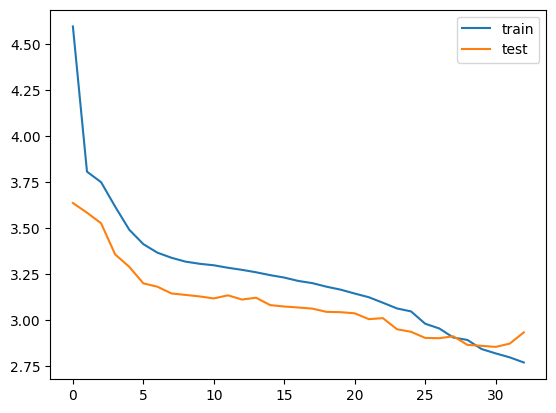

In [ ]:
from matplotlib import pyplot
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [ ]:
reverse_target_word_index=y_tokenizer.index_word
reverse_source_word_index=x_tokenizer.index_word
target_word_index=y_tokenizer.word_index

## Model Inference

Inferencing Encoder and Decoder for getting predicted summary for title

In [ ]:
# Encode the input sequence to get the feature vector
encoder_model = Model(inputs=encoder_inputs,outputs=[encoder_outputs, state_h, state_c])

# Decoder setup
# Below tensors will hold the states of the previous time step
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_hidden_state_input = Input(shape=(max_text_len,latent_dim))

# Get the embeddings of the decoder sequence
dec_emb2= dec_emb_layer(decoder_inputs) 
# To predict the next word in the sequence, set the initial states to the states from the previous time step
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

#attention inference
attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input, decoder_outputs2])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# A dense softmax layer to generate prob dist. over the target vocabulary
decoder_outputs2 = decoder_dense(decoder_inf_concat) 

# Final decoder model
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

In [ ]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    e_out, e_h, e_c = encoder_model.predict(input_seq)
    
    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))
    
    # Populate the first word of target sequence with the start word.
    target_seq[0, 0] = target_word_index['sostok']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
      
        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = reverse_target_word_index[sampled_token_index]
        
        if(sampled_token!='eostok'):
            decoded_sentence += ' '+sampled_token

        # Exit condition: either hit max length or find stop word.
        if (sampled_token == 'eostok'  or len(decoded_sentence.split()) >= (max_summary_len-1)):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # Update internal states
        e_h, e_c = h, c

    return decoded_sentence

In [ ]:
def seq2summary(input_seq):
    newString=''
    for i in input_seq:
        if((i!=0 and i!=target_word_index['sostok']) and i!=target_word_index['eostok']):
            newString=newString+reverse_target_word_index[i]+' '
    return newString

def seq2text(input_seq):
    newString=''
    for i in input_seq:
        if(i!=0):
            newString=newString+reverse_source_word_index[i]+' '
    return newString

Result for Inference is shown below with News Text,original summary and predicted summary

In [ ]:
for i in range(0,100):
    print("News Text:",seq2text(x_tr[i]))
    print("Original News summary:",seq2summary(y_tr[i]))
    print("Predicted News summary:",decode_sequence(x_tr[i].reshape(1,max_text_len)))
    print("\n")

News Text: champions league player returned twice second half topped group nobody probably saw coming ramsey said main target get group finish top fantastic feeling probably best performance involved wales bale added 
Original News summary: win group euro 
1/1 [==============================] - 0s 19ms/step
Predicted News summary:  messi


News Text: advantage generous subsidies car purchases demand strong tax break compact cars started last october said executive officer motor adding true state affairs dire automakers margins narrowing price wars become sales 
Original News summary: fight chinese mar 
1/1 [==============================] - 0s 18ms/step
Predicted News summary:  pakistan


News Text: left host city last week protest event later pcb issued show cause notice younis khan instead pcb chairman shahryar khan accepted younus khan great services pakistan cricket one rule game 
Original News summary: pcb younis play pakistan cu 
1/1 [==============================] - 0s 18ms/ste

KeyError: 0

### References
 - [comprehensive-guide-text-summarization-using-deep-learning](https://www.analyticsvidhya.com/blog/2019/06/comprehensive-guide-text-summarization-using-deep-learning-python/)
 - [a-quick-introduction-to-text-summarization-in-machine-learning](https://towardsdatascience.com/a-quick-introduction-to-text-summarization-in-machine-learning-3d27ccf18a9f)
 - [Keras Text Summarizer](https://github.com/chen0040/keras-text-summarization)

<font color='blue'>If you find this kernel awesome and useful please hit upvote 😊 .</font> <br>
<font color='blue'>Cheers!!!! </font>

<img src="https://global.unitednations.entermediadb.net/assets/mediadb/services/module/asset/downloads/preset/Libraries/Graphics+Library/29-01-2020-WHO-CoronaVirus-anim-public-advice.gif/image1170x530cropped.jpg" width="500" height="500" align="center"/>